In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.transforms import Bbox
import seaborn as sns
import scanpy as sc
import scipy
from matplotlib import patheffects as pe
import sklearn


from importlib import reload

import plotting as plt2

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/geneformer_adata/merged.anndata.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 166691 × 19309
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'cell_type', 'Barcode', 'Library', 'dataset', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'HLF', 'CRHBP', 'CD34', 'MitoCoverage', 'ClonalGroup', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'meanCov', 'ClonalGroup.Prob', 'wsnn_res.0.8', 'Origin.Seurat'
    var: 'gene_name', 'ensemble_id'

In [3]:
pdf = adata.copy()

data = [
    'pellin',
    'iHSC',
    'young2_HSC',
    'tabula_sapiens',
]

mask = pdf.obs['dataset'].isin(data)
pdf = pdf[mask, :]

# drop HSC from tabula
mask = (pdf.obs['celltype'] == 'HSC') & (pdf.obs['dataset'] == 'tabula_sapiens')
pdf = pdf[~mask, :]

# # drop lin- cells from pellin
# mask = (pdf.obs['cell_type'].str.contains('LinNeg')) & (pdf.obs['dataset'] == 'pellin')
# pdf = pdf[~mask, :]


keep_cols = [
    'n_genes',
    'cell_type',
    'dataset',
    'organ_tissue',
    'compartment',
]

pdf.obs = pdf.obs[keep_cols]

sc.pp.filter_genes(pdf, min_counts=3)
sc.pp.filter_cells(pdf, min_counts=100)

sc.pp.normalize_total(pdf)
sc.pp.log1p(pdf)

sc.pp.combat(pdf, key='dataset')

# handle negatives
pdf.X = np.where(pdf.X < 0, 0, pdf.X)

sc.pp.highly_variable_genes(pdf)


pdf

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_combat.py:352: RuntimeWarning: divide by zero encountered in divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


AnnData object with n_obs × n_vars = 60263 × 19114
    obs: 'n_genes', 'cell_type', 'dataset', 'organ_tissue', 'compartment', 'n_counts'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [4]:
sc.tl.pca(pdf, svd_solver="arpack")
sc.pp.neighbors(pdf)
sc.tl.umap(pdf)

print('done')

done


In [5]:
pdf.obs['UMAP 1'] = pdf.obsm['X_umap'][:, 0]
pdf.obs['UMAP 2'] = pdf.obsm['X_umap'][:, 1]

cell_map = {
    'iHSC' : 'iHSC',
    'PreBNK' : 'PreBNK',
    'LinNegCD34lowCD164high' : 'LinNeg',
    'HSC' : 'HSC',
    'CMP' : 'CMP',
    'MEP' : 'MEP',
    'LinNegCD34PosCD164Pos' : 'LinNeg',
    'LinNegCD34NegCD164high' : 'LinNeg',
    'MPP' : "MPP",
    'GMP' : "GMP",
    'LinNegCD34NegCD164low' : 'LinNeg',
    'MLP' : "MLP",
    'FB' : "Fibroblast",
    'MKP' : "MKP"
}

pdf.obs['broad_type'] = pdf.obs['cell_type'].map(cell_map)

In [6]:
root_type = "HSC"
pdf.uns['iroot'] = np.flatnonzero(pdf.obs['cell_type'] == root_type)[0]

sc.tl.diffmap(pdf, n_comps=21)
sc.pp.neighbors(pdf, n_neighbors=7)
sc.tl.dpt(pdf, n_branchings=0)

pdf

AnnData object with n_obs × n_vars = 60263 × 19114
    obs: 'n_genes', 'cell_type', 'dataset', 'organ_tissue', 'compartment', 'n_counts', 'UMAP 1', 'UMAP 2', 'broad_type', 'dpt_pseudotime'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'iroot', 'diffmap_evals'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

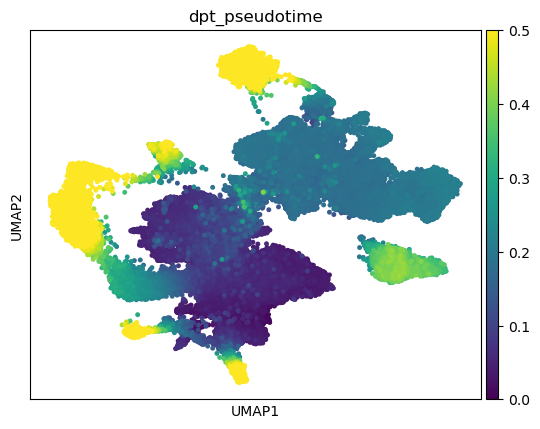

In [7]:
sc.pl.umap(pdf,
           color='dpt_pseudotime',
           vmin=0, 
           vmax=0.5,
           s=50)

/tmp/ipykernel_2527404/2948474301.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  labels = pdf.obs.groupby('broad_type')[['UMAP 1', 'UMAP 2']].median().reset_index()


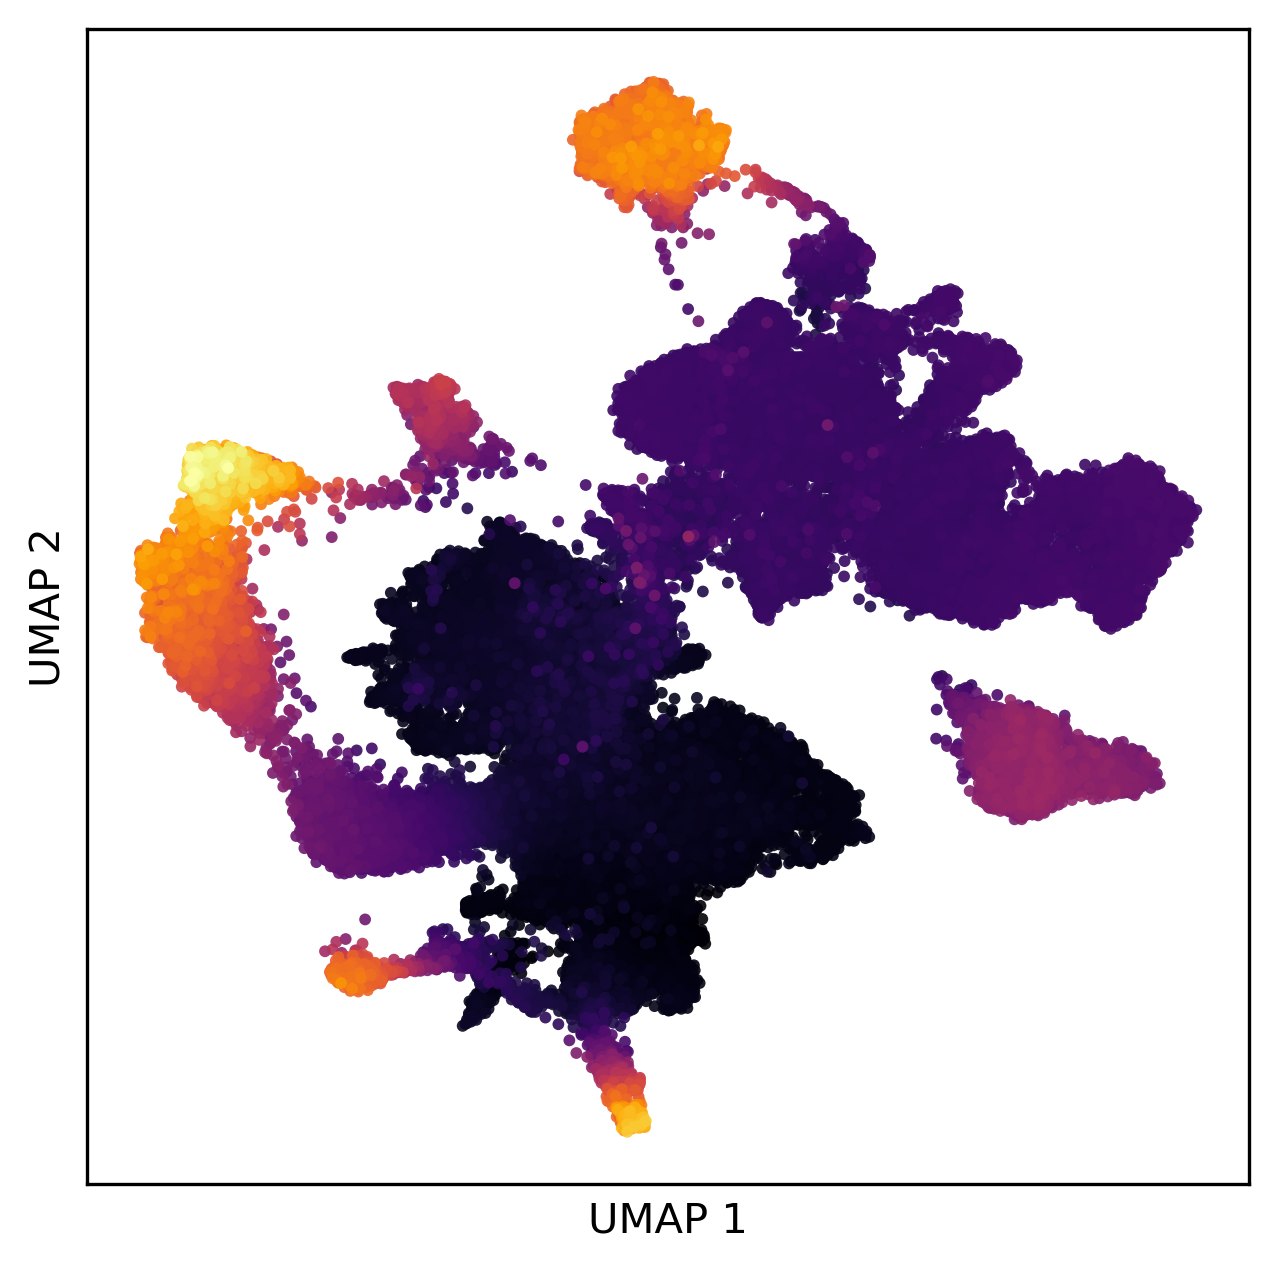

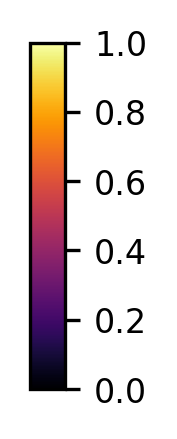

In [8]:
reload(plt2)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

plt2.plot_umap_scatter(pdf, 
                       s=8, 
                       alpha=0.9, 
                       ec='none',
                       cmap='inferno',
                       # colorbar=False,
                       color='dpt_pseudotime')

labels = pdf.obs.groupby('broad_type')[['UMAP 1', 'UMAP 2']].median().reset_index()
keep = [
    'iHSC',
    'HSC',
    'Fibroblast',
    'MPP',
    'CMP',
    'MLP',
    'LinNeg',
]

# print(labels)

# labels = labels[labels['broad_type'].isin(keep)]
# plt2.plot_labels(labels, ax=plt.gca(), label_col='broad_type', text_kwargs={'fontsize':'7', 'path_effects' : None})

# DPT Distance

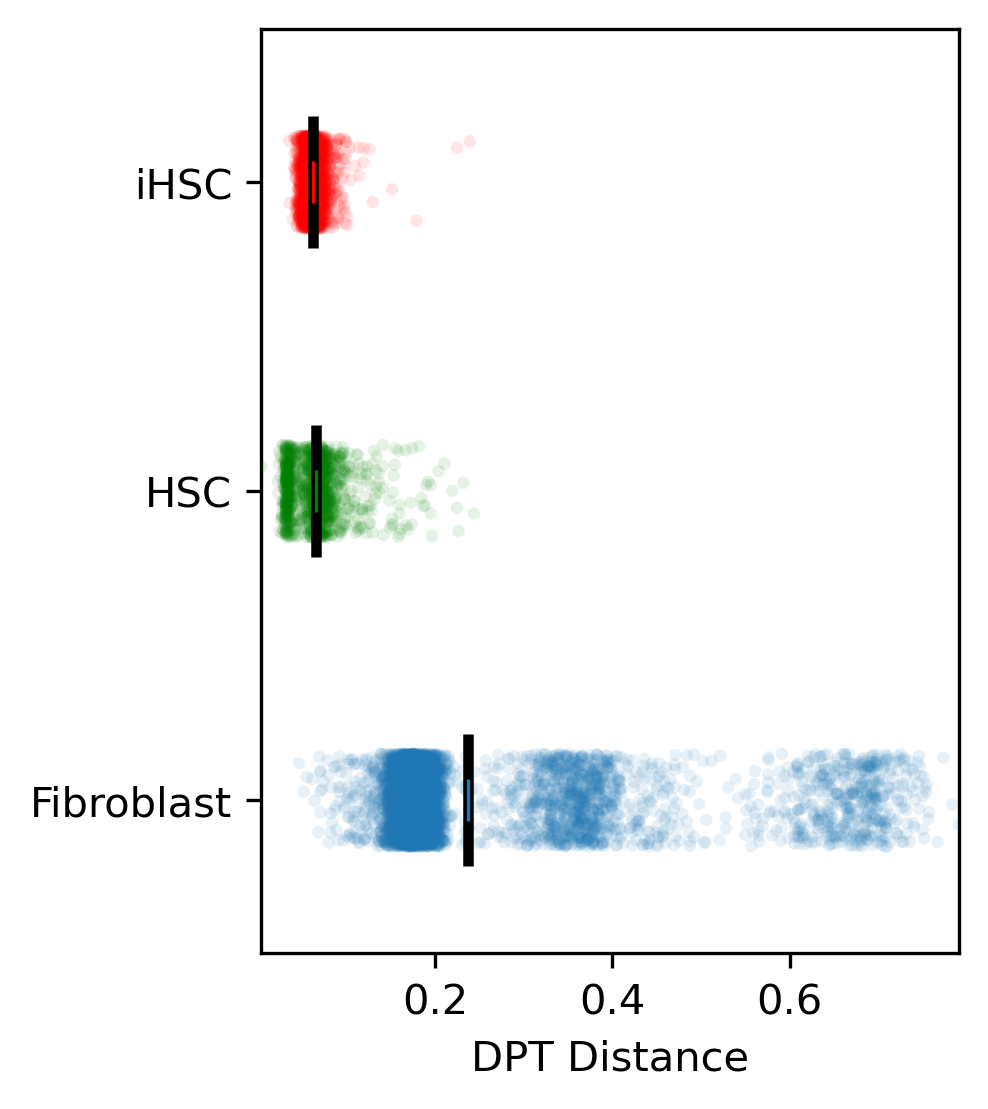

In [126]:
sample_size = 10000
to_plot = pdf.obs.copy()
to_plot['broad_type'] = to_plot['broad_type'].astype(str)

keep = [
    'iHSC',
    'HSC',
    'Fibroblast',
]

to_plot = to_plot[to_plot['broad_type'].isin(keep)]
to_plot = to_plot.sample(sample_size)
to_plot = to_plot.sort_values(by='broad_type')

means = to_plot.groupby('broad_type')['dpt_pseudotime'].mean().reset_index()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 4

sns.stripplot(data=to_plot,
              y='broad_type',
              x='dpt_pseudotime',
              hue='broad_type',
              edgecolor='none',
              jitter=0.15,
              palette=['C0', 'green', 'r'],
              alpha=0.1,
              size=3,
              )


sns.scatterplot(data=means,
              y='broad_type',
              x='dpt_pseudotime',
              hue='broad_type',
              palette=["k", "k", "k"],
              s=1000,
              marker="|",
              alpha=1,
              legend=False,
              zorder=3
              )

sns.scatterplot(data=means,
              y='broad_type',
              x='dpt_pseudotime',
              hue='broad_type',
              palette=['C0', 'green', 'r'],
              s=100,
              marker="|",
              legend=False,
              zorder=10
              )

plt.ylabel("")
plt.xlabel("DPT Distance")
plt.gca().invert_yaxis()
plt.margins(x=0, y=0.15)


# PAGA

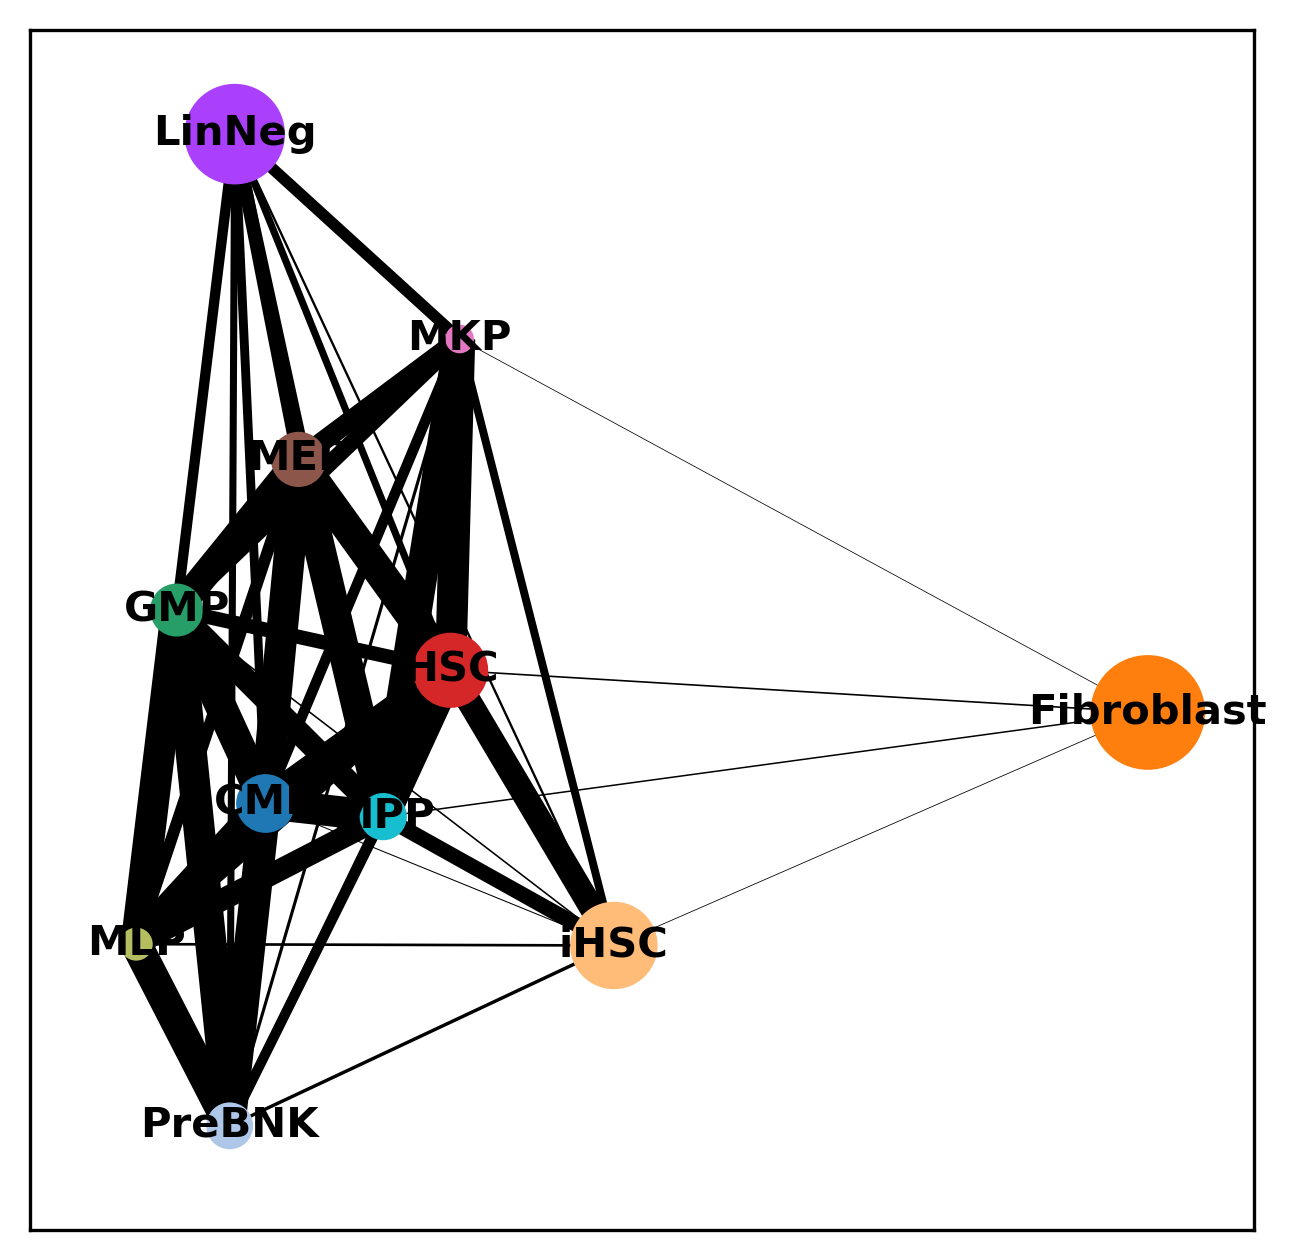

In [9]:
sc.tl.paga(pdf, groups="broad_type")
sc.pl.paga(pdf, color=["broad_type"])

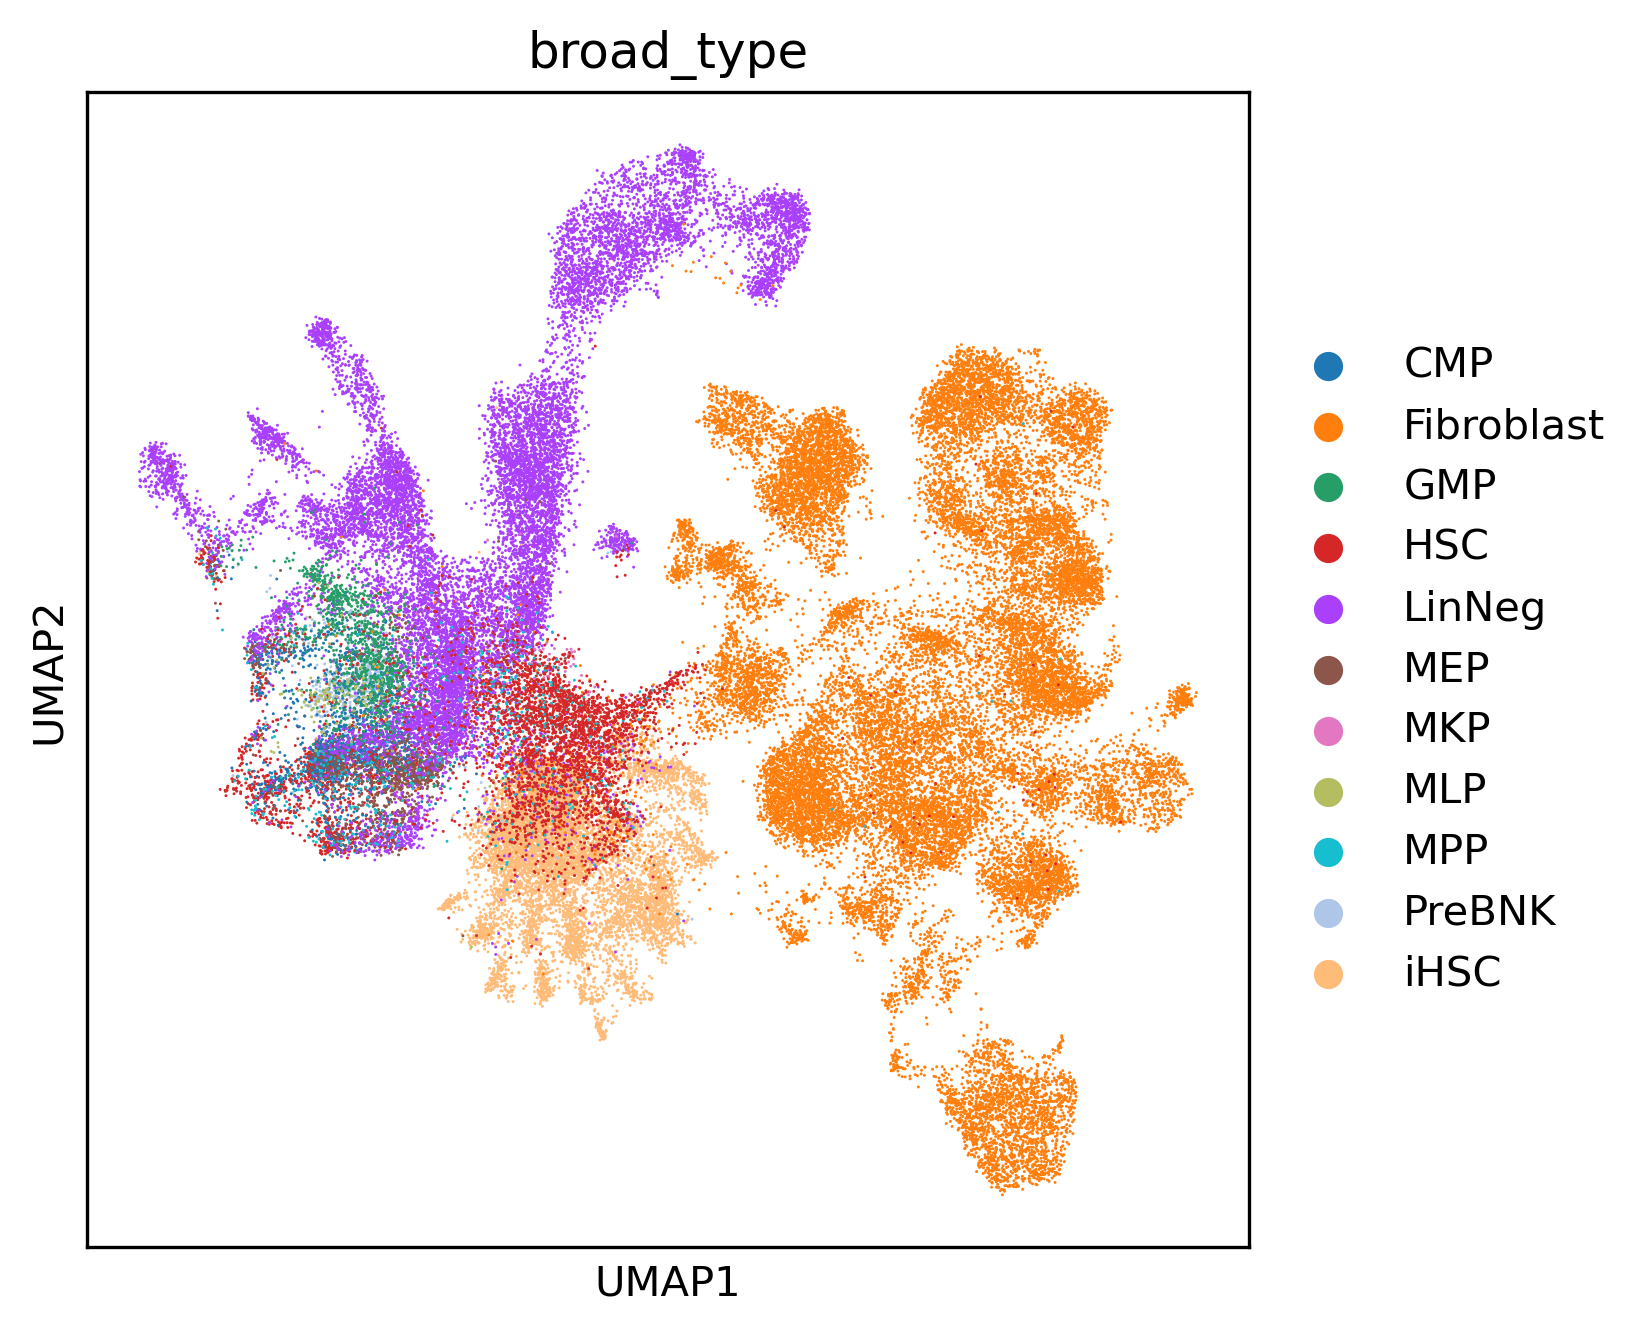

In [10]:
sc.tl.umap(pdf, init_pos='paga')

sc.pl.umap(pdf, color=['broad_type'])